<a href="https://colab.research.google.com/github/jdiazram/DEEP_GEOM/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [ ]:
import numpy as np #
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf # Import TensorFlow 
print(tf.version.VERSION) # Check TensorFlow version
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline 
#hará que las salidas de gráficos aparezcan y se almacenen en el cuaderno

from IPython.display import clear_output #limpiar

2.7.0


# Cargar base de datos

In [ ]:
# Carga de base de datos
!wget https://www.dropbox.com/s/duigf1xgl38tb8o/DG_V2.zip
!unzip DG_V2.zip
!rm DG_V2.zip

clear_output()
print('Base de datos cargada')

Base de datos cargada


# Preprocesamiento

In [ ]:
#carga de datos en variables
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]
#print(train_labels)

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]
#print(validation_labels)
print('Train dataset shape:', train_imgs.shape) 
print('Validation dataset shape:', validation_imgs.shape)
mf_validation = validation_imgs.shape[0]

Train dataset shape: (7000, 150, 150, 3)
Validation dataset shape: (875, 150, 150, 3)


(150, 150, 3)


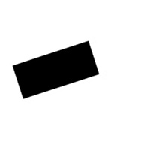

In [ ]:
#normalizacion
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[2556].shape)
array_to_img(train_imgs[2556])

In [ ]:
#Codificación los LABEL mediante One Hot Encoding
batch_size = 30
num_classes = 7
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
train_labels_enc = to_categorical(train_labels_enc, num_classes)
validation_labels_enc = le.transform(validation_labels)
validation_labels_enc = to_categorical(validation_labels_enc, num_classes)

print(train_labels[455:465]) 
print(train_labels_enc[455:465]) #ejemplo de rango

['trapecio', 'cuadrado', 'cuadrado', 'elipse', 'elipse', 'rombo', 'elipse', 'cuadrado', 'rombo', 'rectangulo']
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30, shuffle=True)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=30, shuffle=True)
#input_shape = (150, 150, 3)
print(train_generator.n)
print(val_generator.n)

7000
875


# Modelo Pre-entrenado

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# todos los modelos preentrenados posibles de usar
#pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False ,input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False ,input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False ,input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3]) 
#pretrained_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
pretrained_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
#pretrained_model = tf.keras.applications.Xception(weights='imagenet', input_shape=[*IMG_DIM, 3], include_top=False) 
#pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMG_DIM, 3], include_top=False) 
#uno de los mejores resultados de accuracy junto con DenseNet121
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMG_DIM, 3])
pretrained_model.trainable = False

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
#configuraciones posibles de los modelos, solo usar 1
config_0 = [ #solo modelo transfer learning con M5
    pretrained_model,
    Flatten(),
    Dense(7, activation='softmax')
]

config_1 = [ #modelo M6 base
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
]

config_2 = [ #modelo M7 base
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')
]

config_3 = [ #modelo M8 base
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')
]

config_4 = [ #modelo M9 base
    pretrained_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax')
]

In [ ]:
#modelo
with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential(config_2)

  model.compile(
      optimizer='adam',
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 13824)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1769600   
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 56,141,159
Trainable params: 1,804,423
Non-trainable params: 54,336,736
____________________________________

In [ ]:
#para calcular el tiempo de entrenamiento
import time
start = time.time() #partiendo

# Entrenamiento

Los steps_per_epoch y epochs para los experimentos variaron de la siguiente forma:
*   steps_per_epoch = 30 | epochs = 30
*   steps_per_epoch = 30 | epochs = 100
*   steps_per_epoch = 86 | epochs = 100
*   steps_per_epoch = 233 | epochs = 100

Y según la configuracion anterior, se usó Dropout o no



In [ ]:
with tf.device('/device:GPU:0'):
  steps_per_epoch = train_generator.n//train_generator.batch_size
  epochs = 100

  STEP_SIZE_VAL=val_generator.n//val_generator.batch_size

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/100
233/233 [==============================] - 64s 190ms/step - loss: 1.0683 - accuracy: 0.6224 - val_loss: 0.7170 - val_accuracy: 0.7414
Epoch 2/100
233/233 [==============================] - 41s 174ms/step - loss: 0.7635 - accuracy: 0.7158 - val_loss: 0.6478 - val_accuracy: 0.7598
Epoch 3/100
233/233 [==============================] - 41s 174ms/step - loss: 0.6627 - accuracy: 0.7505 - val_loss: 0.5654 - val_accuracy: 0.7759
Epoch 4/100
233/233 [==============================] - 41s 174ms/step - loss: 0.6533 - accuracy: 0.7525 - val_loss: 0.6138 - val_accuracy: 0.7529
Epoch 5/100
233/233 [==============================] - 40s 172ms/step - loss: 0.6138 - accuracy: 0.7641 - val_loss: 0.5254 - val_accuracy: 0.8069
Epoch 6/100
233/233 [==============================] - 40s 172ms/step - loss: 0.5868 - accuracy: 0.7803 - val_loss: 0.5283 - val_accuracy: 0.8023
Epoch 7/100
233/233 [==============================] - 40s 172ms/step - loss: 0.5899 - accuracy: 0.7811 - val_loss: 0.5891 -

In [ ]:
done = time.time()
elapsed = done - start #terminando
print("Tiempo total de ejecución training/validation", elapsed)

Tiempo total de ejecución training/validation 4121.316334962845


# Gráfico de entrenamiento

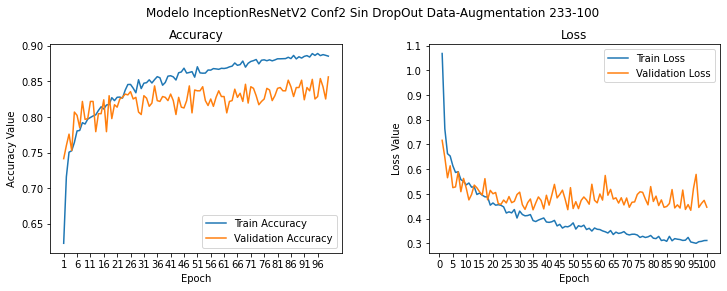

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Modelo InceptionResNetV2 Conf2 Sin DropOut Data-Augmentation 233-100 ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#se guarda modelo luego del entrenamiento
model.save('modeloInceptionResNetV2-Conf2-233-100.h5') #

# Carga del modelo entrenado


In [ ]:
from keras.models import load_model

# cargar el modelo
modelo_InceptionResNetV2 = load_model('modeloInceptionResNetV2-Conf2-233-100.h5')

clear_output()
print('Modelo cargado')

Modelo cargado


# Preprocesamiento de datos de Test

In [ ]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

print('Test dataset shape:', test_imgs.shape)
print(test_labels[100:105])

Test dataset shape: (875, 150, 150, 3)
['elipse', 'cuadrado', 'rombo', 'rombo', 'elipse']


In [ ]:
test_labels_enc = le.transform(test_labels)
test_labels_enc = to_categorical(test_labels_enc, num_classes)

test_eval = modelo_InceptionResNetV2.evaluate(test_imgs_scaled, test_labels_enc, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

28/28 [==============================] - 6s 74ms/step - loss: 0.4113 - accuracy: 0.8709
Test loss: 0.4112904667854309
Test accuracy: 0.8708571195602417


In [ ]:
from sklearn import metrics
import numpy as np

# de numero a etiquetas, según prediccion del modelo
predictions = np.argmax(modelo_InceptionResNetV2.predict(test_imgs_scaled), axis=-1)

test_labels_pred = []

for i in range(875):
    if predictions[i] == 0:
        test_labels_pred.append('circulo')
    elif predictions[i] == 1:
        test_labels_pred.append('cuadrado')
    elif predictions[i] == 2:
        test_labels_pred.append('elipse')
    elif predictions[i] == 3:
        test_labels_pred.append('rectangulo')
    elif predictions[i] == 4:
        test_labels_pred.append('rombo')
    elif predictions[i] == 5:
        test_labels_pred.append('trapecio')
    else:
        test_labels_pred.append('triangulo')

print(test_labels_pred)

['triangulo', 'rectangulo', 'cuadrado', 'circulo', 'triangulo', 'circulo', 'rombo', 'cuadrado', 'rombo', 'circulo', 'triangulo', 'trapecio', 'circulo', 'elipse', 'elipse', 'trapecio', 'cuadrado', 'trapecio', 'elipse', 'rectangulo', 'cuadrado', 'rombo', 'elipse', 'rectangulo', 'elipse', 'triangulo', 'circulo', 'cuadrado', 'elipse', 'trapecio', 'cuadrado', 'circulo', 'elipse', 'trapecio', 'circulo', 'trapecio', 'trapecio', 'rombo', 'circulo', 'elipse', 'rectangulo', 'elipse', 'triangulo', 'rombo', 'circulo', 'rombo', 'rombo', 'trapecio', 'rectangulo', 'rombo', 'circulo', 'rectangulo', 'elipse', 'elipse', 'elipse', 'triangulo', 'trapecio', 'circulo', 'circulo', 'circulo', 'cuadrado', 'rectangulo', 'circulo', 'trapecio', 'cuadrado', 'rombo', 'trapecio', 'rombo', 'rombo', 'cuadrado', 'rombo', 'elipse', 'elipse', 'rectangulo', 'triangulo', 'trapecio', 'rombo', 'triangulo', 'triangulo', 'rectangulo', 'elipse', 'triangulo', 'elipse', 'circulo', 'elipse', 'rectangulo', 'trapecio', 'triangulo', 

In [ ]:
from sklearn import metrics

# Matriz de confusión
print(metrics.confusion_matrix(test_labels, test_labels_pred))

# Precision and recall, F1-score y support
print(metrics.classification_report(test_labels, test_labels_pred, digits=3))

[[117   0   6   1   0   1   0]
 [  5  99   1   5  11   2   2]
 [ 12   0 109   1   0   1   2]
 [  1  12   2 100   3   5   2]
 [  0   1   1   0 116   1   6]
 [  1   0   3   0   6 111   4]
 [  1   1   4   0   5   4 110]]
              precision    recall  f1-score   support

     circulo      0.854     0.936     0.893       125
    cuadrado      0.876     0.792     0.832       125
      elipse      0.865     0.872     0.869       125
  rectangulo      0.935     0.800     0.862       125
       rombo      0.823     0.928     0.872       125
    trapecio      0.888     0.888     0.888       125
   triangulo      0.873     0.880     0.876       125

    accuracy                          0.871       875
   macro avg      0.873     0.871     0.870       875
weighted avg      0.873     0.871     0.870       875

